In [66]:
import boto3
bucket_name = 'dataminds-warehouse'
s3_file_key = 'multisim_dataset.parquet'            # e.g. 'folder/myfile.txt'
local_file_path = 'multisim_dataset.parquet'        # Local destination

# Create an S3 client (remove `bucket_name` here — not a valid argument for boto3.client)
s3 = boto3.client(
    's3',
    region_name='us-east-1'
    # aws_access_key_id='your_access_key',
    # aws_secret_access_key='your_secret_key'
)

# Download the file
try:
    s3.download_file(bucket_name, s3_file_key, local_file_path)
    print(f"✅ File downloaded successfully from s3://{bucket_name}/{s3_file_key} to {local_file_path}")
except Exception as e:
    print("❌ Error downloading file:", e)

✅ File downloaded successfully from s3://dataminds-warehouse/multisim_dataset.parquet to multisim_dataset.parquet


1. trf – tariff used by customer
2. age – customer age in years
3. gndr – gender can be M – male, F – female, U – unknown
4. tenure – customer tenure in days
5. age_dev – age of device
6. dev_man – device manufacturer
7. device_os_name – OS on the device
8. dev_num – number of devices that the sim card was installed in
9. is_dualsim – device’s capability to hold 2 sim cards simultaneously, 0 – No, 1 - Yes
10. is_featurephone – if device is featurephone, 0 – No, 1 - Yes
11. is_smartphone – if device is smartphone, 0 – No, 1 – Yes
12. simcard_type – type of simcard (4G, 3G and etc)
13. region – region of customer
14. target – if subscriber is a multisimmer, 0 -No, 1 – Yes


Your task is to do EDA, Feature Engineering, and then by using XGBoost train the model and fine-tune the hyperparameters. https://xgboost.readthedocs.io/en/stable/ 


You don't have to train data to all dataset, but on sample (if you don't have enough computation power). but explain your steps.
upload jupyter notebook to dataminds-homeworks s3 bucket as yourname-yoursurname-trainmodel.ipynb 


 (Important, - the dataset is not shuffled)  

In [67]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from xgboost import XGBClassifier
from scipy import stats
from sklearn.preprocessing import StandardScaler , LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt 
import seaborn as sns
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler,  StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, cross_validate
import warnings
warnings.filterwarnings('ignore')

In [68]:
!pip install category_encoders

In [69]:
df = pd.read_parquet('multisim_dataset.parquet')
df.shape

(10000, 132)

In [70]:
df.head()

,telephone_number,trf,age,gndr,tenure,age_dev,dev_man,device_os_name,dev_num,is_dualsim,...,val13_6,val14_6,val15_6,val16_6,val17_6,val18_6,val19_6,val20_6,val21_6,target
9626,iWBn_13aJO,J,50,M,6957.0,1263,Samsung,Android OS,1,1,...,0.000000,0.0,0.00,0.56,0.00,0.00,60.0,7.0,0.0,1
34347,8JWaD2wYoQ,M,52,M,1041.0,125,Samsung,Android OS,2,1,...,206.536585,0.0,0.40,0.00,0.16,0.24,156.0,0.0,2.0,1
72797,sbPnQURi3j,A,49,U,7176.0,345,Samsung,Android OS,1,1,...,0.000000,0.0,0.25,2.35,0.00,0.25,241.0,87.0,4.0,1
68025,qOy-JlqPTl,M,49,M,4309.0,466,Samsung,Android OS,1,1,...,51.885746,0.0,0.00,0.00,0.00,0.00,299.0,142.0,80.0,1
31781,MNODhcb7h0,A,50,U,6999.0,695,Samsung,Android OS,1,1,...,0.000000,0.0,0.00,0.80,0.00,0.00,121.0,96.0,0.0,1


In [71]:
df.describe()

,tenure,val2_1,val3_1,val4_1,val5_1,val6_1,val7_1,val8_1,val9_1,val10_1,...,val13_6,val14_6,val15_6,val16_6,val17_6,val18_6,val19_6,val20_6,val21_6,target
count,9974.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,9728.000000,9728.000000,9.728000e+03,9.728000e+03,9.728000e+03,9.728000e+03,9728.000000,9728.000000,9728.000000,10000.000000
mean,3705.959996,12.236181,3.446700,83.165400,132.10566,26.930500,32.450760,10.987100,13.048270,14.784100,...,2028.914189,0.141146,8.848952e-01,1.577953e+00,3.542630e-01,4.751151e-01,185.486842,67.556127,20.955387,0.500000
std,2662.023191,16.818445,4.948314,161.116319,322.39447,61.231913,84.935862,29.115987,42.586931,37.451093,...,9118.745830,2.658871,2.040635e+00,2.878263e+00,1.045168e+00,1.238263e+00,259.493942,132.488722,49.859408,0.500025
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-6.183982e-08,-1.108646e-07,-3.352761e-08,-3.576279e-08,0.000000,0.000000,0.000000,0.000000
25%,1256.250000,2.000000,1.000000,4.000000,3.37500,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,37.000000,3.000000,0.000000,0.000000
50%,3022.500000,6.000000,2.000000,26.000000,31.00000,5.000000,4.500000,1.000000,0.900000,2.000000,...,0.000000,0.000000,1.500000e-01,4.400000e-01,0.000000e+00,1.072884e-08,96.000000,20.000000,4.000000,0.500000
75%,6261.000000,16.000000,4.000000,85.000000,114.00000,23.000000,23.200000,8.000000,8.000000,11.000000,...,200.062908,0.000000,9.000000e-01,2.000000e+00,3.000000e-01,4.200000e-01,223.000000,67.000000,18.000000,1.000000
max,8978.000000,325.000000,90.000000,2628.000000,6219.30000,940.000000,2176.100000,504.000000,1667.600000,567.000000,...,159548.365647,192.462886,4.920000e+01,5.918000e+01,3.464000e+01,2.886000e+01,4488.000000,1958.000000,1070.000000,1.000000


In [72]:
for x, y in df.isna().sum().items():
    print(f'{x}            {y}')

telephone_number            0
trf            0
age            24
gndr            0
tenure            26
age_dev            20
dev_man            20
device_os_name            20
dev_num            20
is_dualsim            0
is_featurephone            0
is_smartphone            0
simcard_type            349
region            96
val2_1            0
val3_1            0
val4_1            0
val5_1            0
val6_1            0
val7_1            0
val8_1            0
val9_1            0
val10_1            0
val11_1            0
val12_1            0
val13_1            0
val14_1            0
val15_1            0
val16_1            0
val17_1            0
val18_1            0
val19_1            0
val20_1            0
val21_1            0
val2_2            160
val3_2            160
val4_2            160
val5_2            160
val6_2            160
val7_2            160
val8_2            160
val9_2            160
val10_2            160
val11_2            160
val12_2            160
val13_2        

In [73]:
df['age'] = pd.to_numeric(df['age'])

In [74]:
df['age_dev'] = pd.to_numeric(df['age_dev'])

In [75]:
for x, y in df.dtypes.items():
    print(f'{x}    {y}')

telephone_number    object
trf    object
age    float64
gndr    object
tenure    float64
age_dev    float64
dev_man    object
device_os_name    object
dev_num    object
is_dualsim    object
is_featurephone    object
is_smartphone    object
simcard_type    object
region    object
val2_1    float64
val3_1    float64
val4_1    int64
val5_1    float64
val6_1    int64
val7_1    float64
val8_1    int64
val9_1    float64
val10_1    int64
val11_1    float64
val12_1    float64
val13_1    float64
val14_1    float64
val15_1    float64
val16_1    float64
val17_1    float64
val18_1    float64
val19_1    int64
val20_1    int64
val21_1    int64
val2_2    float64
val3_2    float64
val4_2    float64
val5_2    float64
val6_2    float64
val7_2    float64
val8_2    float64
val9_2    float64
val10_2    float64
val11_2    float64
val12_2    float64
val13_2    float64
val14_2    float64
val15_2    float64
val16_2    float64
val17_2    float64
val18_2    float64
val19_2    float64
val20_2    float64
val21_2  

In [76]:
df = df[df['age'] < 150]#one value 1941 exists

<Axes: xlabel='age'>

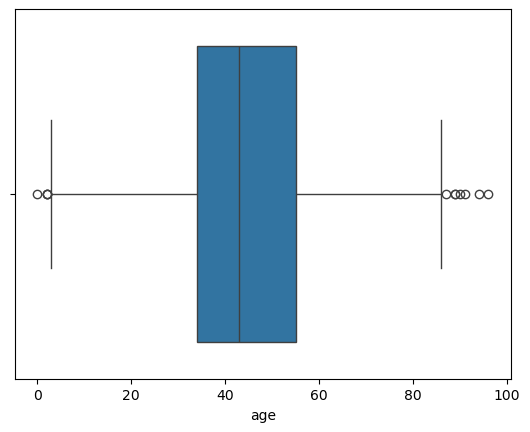

In [77]:
sns.boxplot(data = df, x = 'age')

<Axes: xlabel='trf', ylabel='count'>

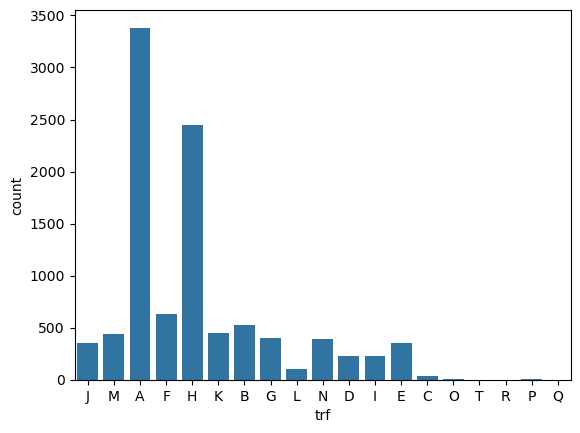

In [78]:
sns.countplot(data = df, x = df['trf'])

<Axes: xlabel='simcard_type', ylabel='trf'>

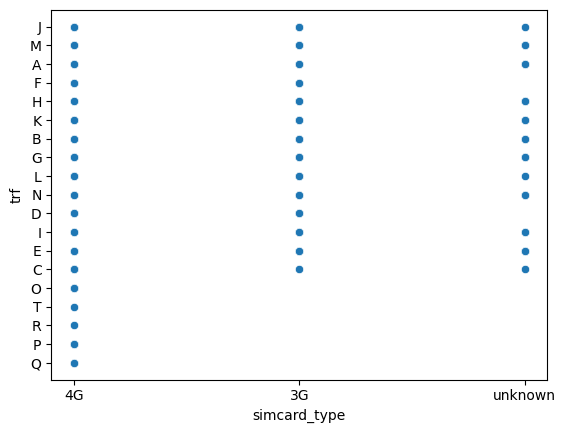

In [79]:
sns.scatterplot(data = df, x = 'simcard_type', y = 'trf')

<Axes: xlabel='trf', ylabel='age'>

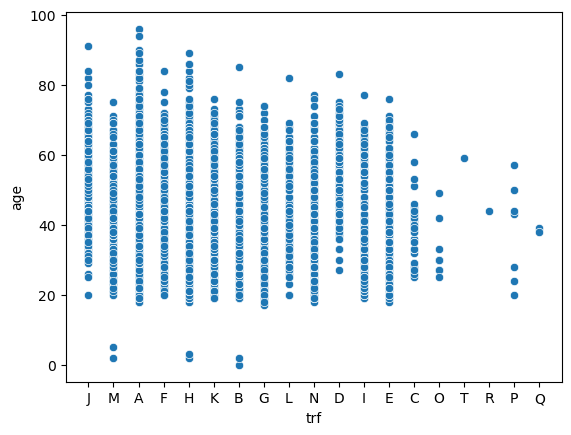

In [80]:
sns.scatterplot(data = df, x = 'trf', y = 'age')

<Axes: xlabel='age', ylabel='Count'>

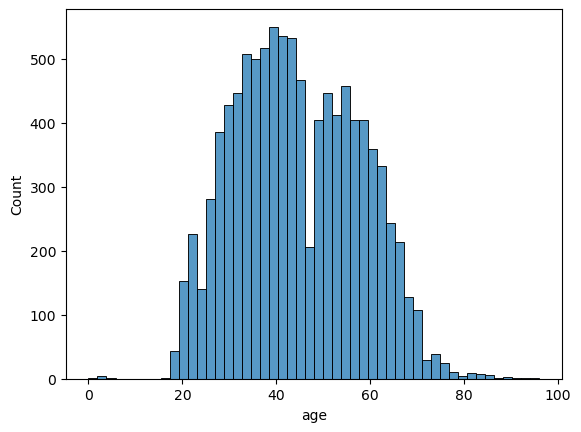

In [81]:
sns.histplot(data = df, x = df['age'])

In [82]:
print(df['age'].unique())


[50. 52. 49. 44. 73. 68. 34. 41. 56. 67. 36. 40. 46. 48. 32. 66. 31. 35.
 25. 42. 29. 26. 37. 45. 39. 51. 61. 43. 57. 30. 33. 19. 54. 47. 62. 28.
 55. 69. 27. 60. 63. 64. 72. 65. 38. 24. 58. 59. 23. 53. 20. 18. 71. 21.
 22. 70. 75. 74. 77.  0. 86. 17. 83. 96.  5. 78. 79. 82. 89.  2. 81. 76.
 84.  3. 80. 94. 85. 91. 90. 87.]


In [83]:
for x, y in df['age'].value_counts().items():
    print(x, '  ==>    ', y)

39.0   ==>     290
43.0   ==>     276
41.0   ==>     272
38.0   ==>     265
42.0   ==>     264
40.0   ==>     260
44.0   ==>     256
34.0   ==>     255
33.0   ==>     252
37.0   ==>     252
36.0   ==>     251
35.0   ==>     249
45.0   ==>     241
54.0   ==>     241
50.0   ==>     240
32.0   ==>     230
46.0   ==>     226
29.0   ==>     224
55.0   ==>     217
31.0   ==>     216
28.0   ==>     213
52.0   ==>     213
57.0   ==>     209
58.0   ==>     207
49.0   ==>     207
51.0   ==>     206
47.0   ==>     206
30.0   ==>     203
53.0   ==>     199
59.0   ==>     197
48.0   ==>     197
56.0   ==>     196
60.0   ==>     183
61.0   ==>     176
62.0   ==>     174
27.0   ==>     173
63.0   ==>     158
25.0   ==>     148
64.0   ==>     142
24.0   ==>     140
26.0   ==>     133
23.0   ==>     122
66.0   ==>     110
22.0   ==>     104
67.0   ==>     103
65.0   ==>     102
21.0   ==>     84
68.0   ==>     73
20.0   ==>     68
70.0   ==>     57
69.0   ==>     55
71.0   ==>     51
19.0   ==>     35


In [84]:
X = df.drop('target', axis = 1)
y = df['target']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [86]:
num_cols = X_train.select_dtypes(include = 'number').columns.to_list()
cat_cols = X_train.select_dtypes(include = 'object').columns.to_list()

In [87]:
for x, y in X_train.isna().sum().items():
    print(f'{x}   {y}')

telephone_number   0
trf   0
age   0
gndr   0
tenure   19
age_dev   16
dev_man   16
device_os_name   16
dev_num   16
is_dualsim   0
is_featurephone   0
is_smartphone   0
simcard_type   277
region   74
val2_1   0
val3_1   0
val4_1   0
val5_1   0
val6_1   0
val7_1   0
val8_1   0
val9_1   0
val10_1   0
val11_1   0
val12_1   0
val13_1   0
val14_1   0
val15_1   0
val16_1   0
val17_1   0
val18_1   0
val19_1   0
val20_1   0
val21_1   0
val2_2   121
val3_2   121
val4_2   121
val5_2   121
val6_2   121
val7_2   121
val8_2   121
val9_2   121
val10_2   121
val11_2   121
val12_2   121
val13_2   121
val14_2   121
val15_2   121
val16_2   121
val17_2   121
val18_2   121
val19_2   121
val20_2   121
val21_2   121
val2_3   146
val3_3   146
val4_3   146
val5_3   146
val6_3   146
val7_3   146
val8_3   146
val9_3   146
val10_3   146
val11_3   146
val12_3   146
val13_3   146
val14_3   146
val15_3   146
val16_3   146
val17_3   146
val18_3   146
val19_3   146
val20_3   146
val21_3   146
val2_4   170
val4_4   1

In [88]:
X_train.shape

(7980, 131)

In [91]:
pipe_num = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
pipe_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('catboost', CatBoostEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('numerical',pipe_num, num_cols),
    ('categorical', pipe_cat, cat_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42))
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [92]:
X = df.drop('target', axis=1)
y = df['target']
scoring = ['accuracy' , 'precision', 'recall' , 'f1', 'roc_auc']
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring, return_train_score=False)
for metric in scoring:
    test_scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()} scores: {test_scores}")
    print(f"Mean {metric}: {test_scores.mean():.4f}\n")

Accuracy scores: [0.49223058 0.47568922 0.50325815 0.52080201 0.50776942]
Mean accuracy: 0.4999

Precision scores: [0. 0. 0. 0. 0.]
Mean precision: 0.0000

Recall scores: [0. 0. 0. 0. 0.]
Mean recall: 0.0000

F1 scores: [0. 0. 0. 0. 0.]
Mean f1: 0.0000

Roc_auc scores: [0.5026549  0.49690829 0.46713097 0.48309648 0.50081125]
Mean roc_auc: 0.4901



In [ ]:
import boto3
bucket_name = 'dataminds-homework'
s3_file_key = 'ravana-gurbanova-trainmodel.ipynb'            # e.g. 'folder/myfile.txt'
local_file_path = 'multisim_dataset.parquet'        # Local destination

# Create an S3 client (remove `bucket_name` here — not a valid argument for boto3.client)
s3 = boto3.client(
    's3',
    region_name='us-east-1'
    # aws_access_key_id='your_access_key',
    # aws_secret_access_key='your_secret_key'
)

# Download the file
try:
    s3.download_file(bucket_name, s3_file_key, local_file_path)
    print(f"✅ File downloaded successfully from s3://{bucket_name}/{s3_file_key} to {local_file_path}")
except Exception as e:
    print("❌ Error downloading file:", e)